In [3]:
import pandas as pd
import numpy as np
import yfinance as yf 
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib 
import pandas_datareader.data as web

In [4]:
doge_data = yf.download('DOGE-USD', start='2017-01-01', end='2022-01-01')


[*********************100%***********************]  1 of 1 completed


In [5]:
doge_df = pd.DataFrame(doge_data)

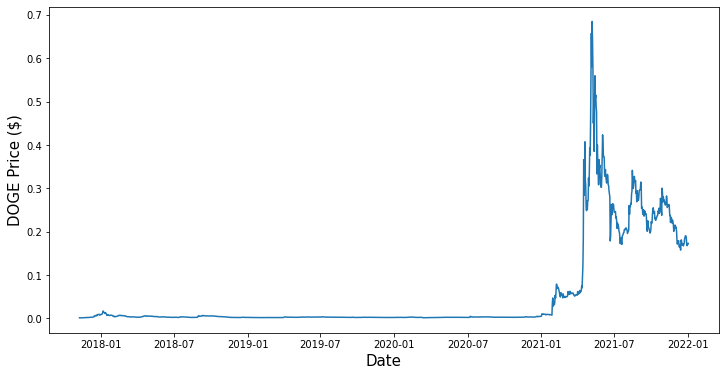

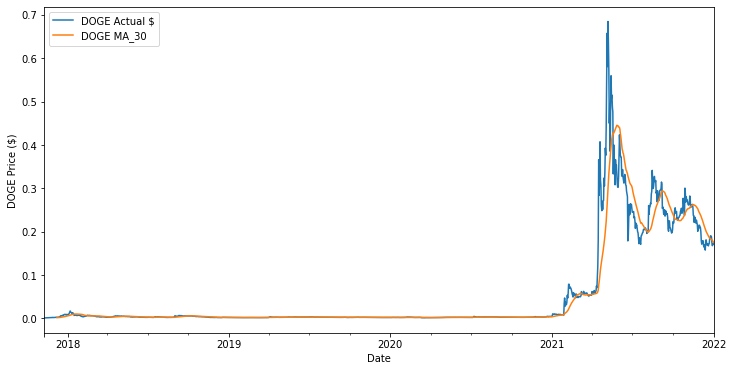

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(doge_df["Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('DOGE Price ($)',fontsize=15)
plt.show()

close_px = doge_df['Close']
mavg = close_px.rolling(window=30).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='DOGE Actual $')
mavg.plot(label='DOGE MA_30')
plt.xlabel('Date')
plt.ylabel('DOGE Price ($)')
plt.legend()

In [7]:
import matplotlib.dates as mdates

dates_df = doge_df.copy()
dates_df = dates_df.reset_index()

org_dates = dates_df['Date']

dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1510,738152.0,0.187847,0.187885,0.172738,0.174117,0.174117,954075337
1511,738153.0,0.174095,0.177339,0.166760,0.167765,0.167765,823628336
1512,738154.0,0.168137,0.175771,0.165381,0.171313,0.171313,599236772
1513,738155.0,0.171317,0.175294,0.167307,0.170496,0.170496,644416694
1514,738156.0,0.170510,0.173423,0.170353,0.173035,0.173035,371336089


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
prices = np.array(doge_df['Close'])
prices = np.reshape(prices, (-1, 1))

scaler.fit(prices)
prices = scaler.transform(prices)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


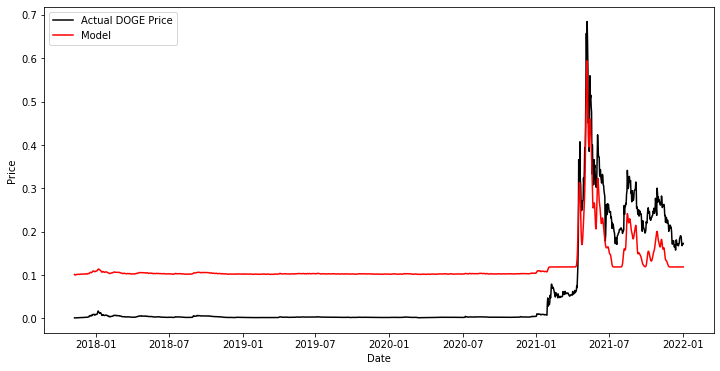

In [9]:
from sklearn.svm import SVR
from sklearn import svm
svr_model = svm.SVR()

dates = np.array(dates_df['Date'])
prices = np.array(doge_df['Close'])

dates = np.reshape(dates, (-1, 1)) 
prices = np.reshape(prices, (-1, 1)) 

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices) 

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Actual DOGE Price')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'Model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:

train_data = prices
print(train_data.shape) 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1515, 1)


In [11]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1479, 36, 1)
X_train:
[[0.001415]
 [0.001163]
 [0.001201]
 [0.001038]
 [0.001211]
 [0.001184]
 [0.001339]
 [0.00139 ]
 [0.001313]
 [0.001373]
 [0.001376]
 [0.001394]
 [0.001389]
 [0.001823]
 [0.001891]
 [0.001908]
 [0.002072]
 [0.002026]
 [0.001988]
 [0.002363]
 [0.00208 ]
 [0.002079]
 [0.002148]
 [0.002149]
 [0.002223]
 [0.002463]
 [0.002479]
 [0.002663]
 [0.00272 ]
 [0.002779]
 [0.002617]
 [0.002547]
 [0.002798]
 [0.003304]
 [0.003461]
 [0.003709]]


y_train: [[0.003762]]



In [12]:
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
104/104 [==============================] - 10s 55ms/step - loss: 1.5349e-05 - val_loss: 0.0412
Epoch 2/20
104/104 [==============================] - 5s 48ms/step - loss: 3.7124e-06 - val_loss: 0.0105
Epoch 3/20
104/104 [==============================] - 5s 47ms/step - loss: 2.7842e-06 - val_loss: 0.0068
Epoch 4/20
104/104 [==============================] - 5s 48ms/step - loss: 2.4127e-06 - val_loss: 0.0063
Epoch 5/20
104/104 [==============================] - 5s 47ms/step - loss: 2.3930e-06 - val_loss: 0.0070
Epoch 6/20
104/104 [==============================] - 5s 47ms/step - loss: 2.0316e-06 - val_loss: 0.0074
Epoch 7/20
104/104 [==============================] - 5s 48ms/step - loss: 2.5545e-06 - val_loss: 0.0052
Epoch 8/20
104/104 [==============================] - 5s 48ms/step - loss: 1.9417e-06 - val_loss: 0.0046
Epoch 9/20
104/104 [==============================] - 5s 47ms/step - loss: 2.2166e-06 - val_loss: 0.0054
Epoch 10/20
104/104 [==============================] -

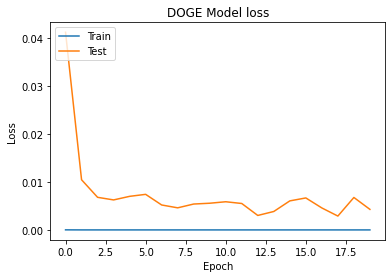

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DOGE Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
model.evaluate(X_train, y_train)

47/47 [==============================] - 1s 20ms/step - loss: 0.0013


0.0012879862915724516

In [14]:
predicted = model.predict(X_train)

In [15]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

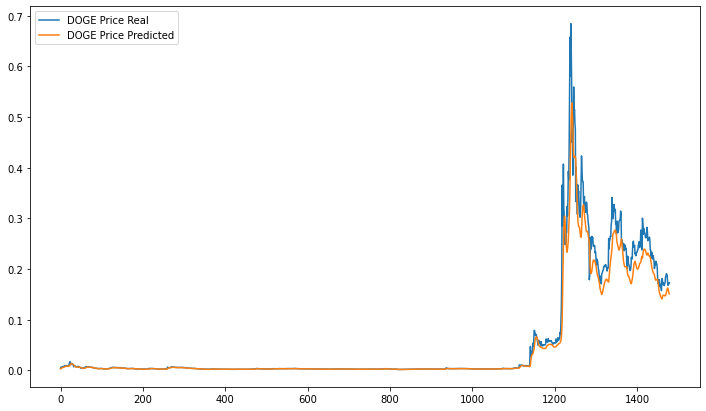

In [16]:
stocks = pd.DataFrame({
    'DOGE Price Real': real_prices.ravel(),
    'DOGE Price Predicted': predicted_prices.ravel()},
)
stocks.head()

stocks.plot(figsize=(12,7))